# DE609-norderstedt analysis of initial land survey

The first order of business is to read the CSV file containing the ETRS89 measurements of the surface of the Norderstedt station.

In [1]:
%pylab inline

# From final field validation
CHBA_ETRS = array([ 3727218.128, 655108.821, 5117002.847])
CLBA_ETRS = array([ 3727207.778, 655184.900, 5117000.625])
LBA_ROTATION_MATRIX = array([
    [-0.13845476655396716, -0.8005033400537694, 0.583116352181317],
    [0.9900288727081186, -0.09644869337822555, 0.10266684347892051],
    [-0.025944340862288206, 0.591516738654446, 0.8058752006786344]])
HBA_ROTATION_MATRIX = array([
    [-0.13825859450116507, -0.8005279672120733, 0.5831290892742945],
    [0.9900632957052748, -0.0964516605828844, 0.10233155753731976],
    [-0.025675504742305157, 0.5914829252667483, 0.8059086285517225]])

import csv

def read_etrs_csv(file_name, delimiter=';'):
    with open(file_name, 'r') as csv_file:
        csv_rows = [(row[0], array([float(num) for num in row[1:4]])) 
                    for row in csv.reader(csv_file, delimiter=delimiter)
                    if 'ETRS' not in row[1] and 'ECEF' not in row[1]]
    return csv_rows

def names_from_rows(csv_rows):
    return [row[0] for row in csv_rows]

def positions_from_rows(csv_rows):
    return array([row[1] for row in csv_rows])

csv_rows = read_etrs_csv('Feld_ETRS89_2000_2-sorted.csv')    
print len(csv_rows)
csv_rows[0:3]

Populating the interactive namespace from numpy and matplotlib
397


[('1', array([ 3727223.962,   655108.048,  5116998.574])),
 ('2', array([ 3727216.079,   655106.754,  5117004.592])),
 ('3', array([ 3727208.2  ,   655105.461,  5117010.617]))]

It seems like we succeeded in reading the file. The variable *position_dict* can be used to look up positions based on the name of the point. *all_positions* is an array of all 3D ETRS coordinates, and *all_names* holds the corresponding names.

In [2]:
position_dict = dict(csv_rows)
all_positions = positions_from_rows(csv_rows)
all_names = names_from_rows(csv_rows)
mean_position = all_positions.mean(axis=0)
print 'Mean position (ETRS89): ', mean_position

Mean position (ETRS89):  [ 3727257.65551889   655197.97431738  5116961.50287658]


And in geographic coordinates in radians and meters:

In [3]:
from lofargeo import *
geo_mean = geographic_from_xyz(mean_position)
print '''lat_rad : %(lat_rad).10f rad
lon_rad : %(lon_rad).10f rad
height_m: %(height_m).3f m''' % geo_mean

lat_rad : 0.9372048971 rad
lon_rad : 0.1740077557 rad
height_m: 67.246 m


The normal vector to the WGS84 ellipsoid is then

In [4]:
ellipsoid_normal = normal_vector_ellipsoid(geo_mean['lon_rad'], geo_mean['lat_rad'])
repr(ellipsoid_normal)

'array([ 0.58310237,  0.10250096,  0.80590643])'

## Slope of the field and selection of subset of points

The first inspection of the data is done with respect to the plane parallel to the tangent plane of the WGS84 ellipsoid at the mean position of all measured points, that goes right through the mean coordinate of all measured points. We determine a transformation_matrix that ensures that transformed "x" will be pointing east, "y" towards geographic north, and "z" up and perpendicular to the tangent plane of the ellipsoid at the longitude and latitude of the mean position.

In [5]:
local_north_projection = projection_matrix(mean_position, ellipsoid_normal)
local_north_xyz = transform(all_positions, mean_position, local_north_projection.T)

In [6]:
with open('14145T01_Messpunkte_ECEF.csv', 'r') as csv_file:
    second_survey_points_rows = [(row[0], array([float(num) for num in row[1:4]])) 
                for row in csv.reader(csv_file, delimiter=',')
                if 'ETRS' not in row[1]]
second_survey_names = [row[0] for row in second_survey_points_rows]
second_survey_etrs = array([row[1] for row in second_survey_points_rows])
second_survey_xyz  = transform(second_survey_etrs, mean_position, local_north_projection.T)
for name, offset_xyz, etrs in zip(second_survey_names, second_survey_xyz, second_survey_etrs):
    print('%s: %r; %r' %(name, offset_xyz, etrs))
refp_1024_origin_etrs = (transform(array([ [-89.04172342,  127.80078294,    0.0]]), array([0,0,0]), local_north_projection) + mean_position)[0,:]
print refp_1024_origin_etrs

50: array([-155.80768538,  110.98599513,    0.98603271]); array([ 3727197.112,   655029.135,  5117028.006])
51: array([-141.71829431,    9.06211459,    0.15878094]); array([ 3727275.091,   655057.148,  5116966.996])
52: array([-50.57686798,  16.37135904,   0.33201883]); array([ 3727253.611,   655145.911,  5116971.463])
53: array([ 81.14934107,   8.8992277 ,   0.38515466]); array([ 3727236.767,   655276.696,  5116967.082])
54: array([  68.00038413,  126.40025274,    1.56562583]); array([ 3727146.467,   655247.472,  5117037.599])
55: array([  -5.86024367,  137.14816851,    1.93511351]); array([ 3727150.939,   655173.265,  5117044.26 ])
1000: array([  64.15287914,  135.87861413,    1.47678572]); array([ 3727139.558,   655242.351,  5117043.139])
1001: array([  64.26524869,  138.92575279,    1.4717766 ]); array([ 3727137.117,   655242.036,  5117044.939])
1002: array([  64.30768466,  131.13507805,    1.55170382]); array([ 3727143.34 ,   655243.173,  5117040.391])
1003: array([  -7.25462033, 

In a second site survey at 2014-09-03, land surveyors determined the ETRS coordinates of several trees near the field. These can be used to determine the intended ETRS coordinates for the field centres. We use tree number "1024" (the westernmost tree on the northern tree line) as our origin, and project its ETRS coordinates to the plane parallel to the ellipsoid at the field centre.

In [7]:
refp_1024_origin_etrs = (transform(array([ [-89.04172342,  127.80078294,    0.0]]), array([0,0,0]), local_north_projection) + mean_position)[0,:]
print refp_1024_origin_etrs

[ 3727171.6312795    655092.44552442  5117037.16642608]


The xycoordinates for the HBA and LBA centres in this local coordinate system are

In [8]:
CHBA_XYZ_1024 = array([6.0361, -60.4211, 0.0])
CLBA_XYZ_1024 = array([84.8, -63.225, 0.0])
CABINET_XYZ_1024 = array([47.4452, -25.0258, 0.0]) # EAST_WEST (3.5x7.5)
CABINET_CORNERS_XYZ_1024 = 0.5*array(
    [[-7.5, +3.5, 0.0],
     [+7.5, +3.5, 0.0],
     [+7.5, -3.5, 0.0],
     [-7.5, -3.5, 0.0]]) + CABINET_XYZ_1024[newaxis, :]
print CABINET_CORNERS_XYZ_1024
POINT_1_CABLE_CABINET= array([49.1726, -28.0052, 0.0])

TREE_1021_1024 = array([177.13504, -108.4496, 0.0])
CHBA_ETRS_1024 = transform(array([CHBA_XYZ_1024]), array([0.0,0.0,0.0]), local_north_projection)[0,:] + refp_1024_origin_etrs
CLBA_ETRS_1024 = transform(array([CLBA_XYZ_1024]), array([0.0,0.0,0.0]), local_north_projection)[0,:] + refp_1024_origin_etrs
TREE_1021_ETRS_1024 = transform(array([TREE_1021_1024]), array([0.0,0.0,0.0]), local_north_projection)[0,:] + refp_1024_origin_etrs
print repr(CHBA_ETRS_1024)
print repr(CLBA_ETRS_1024)
print TREE_1021_ETRS_1024
print transform(array([TREE_1021_ETRS_1024]), refp_1024_origin_etrs, local_north_projection.T)
print 'tree 1021', transform(array([array([ 3727230.757,   655274.889,  5116971.925])]), refp_1024_origin_etrs, local_north_projection.T)
print 'tree 1023', transform(array([array([ 3727144.564,   655235.551,  5117040.787])]), refp_1024_origin_etrs, local_north_projection.T)
print 177.135/169.451
print 111.012/ 108.450
CABINET_ETRS = transform(array([CABINET_XYZ_1024]), array([0.0,0.0,0.0]), local_north_projection)[0,:] + refp_1024_origin_etrs
CABINET_CORNERS_ETRS = transform(CABINET_CORNERS_XYZ_1024, array([0.0,0.0,0.0]), local_north_projection) + refp_1024_origin_etrs[newaxis,:]
POINT_1_CABLE_ETRS = transform(array([POINT_1_CABLE_CABINET]), array([0.0,0.0,0.0]), local_north_projection)[0,:] + refp_1024_origin_etrs
CABINET_ETRS, POINT_1_CABLE_ETRS, CABINET_CORNERS_ETRS

print geographic_from_xyz(CABINET_ETRS)

[[ 43.6952 -23.2758   0.    ]
 [ 51.1952 -23.2758   0.    ]
 [ 51.1952 -26.7758   0.    ]
 [ 43.6952 -26.7758   0.    ]]
array([ 3727218.54466316,   655106.82086847,  5117001.39454123])
array([ 3727207.13375049,   655184.78656076,  5116999.73451207])
[ 3727227.04410212   655282.03730082  5116972.95960755]
[[  1.77135040e+02  -1.08449600e+02   1.12947873e-10]]
tree 1021 [[ 169.45186942 -111.01181034    0.59849499]]
tree 1023 [[ 145.63059704    3.66068841    1.80329775]]
1.04534644233
1.02362378976
{'lat_rad': 0.93722101348049602, 'height_m': 67.246568409726024, 'lon_rad': 0.1739967639460985}


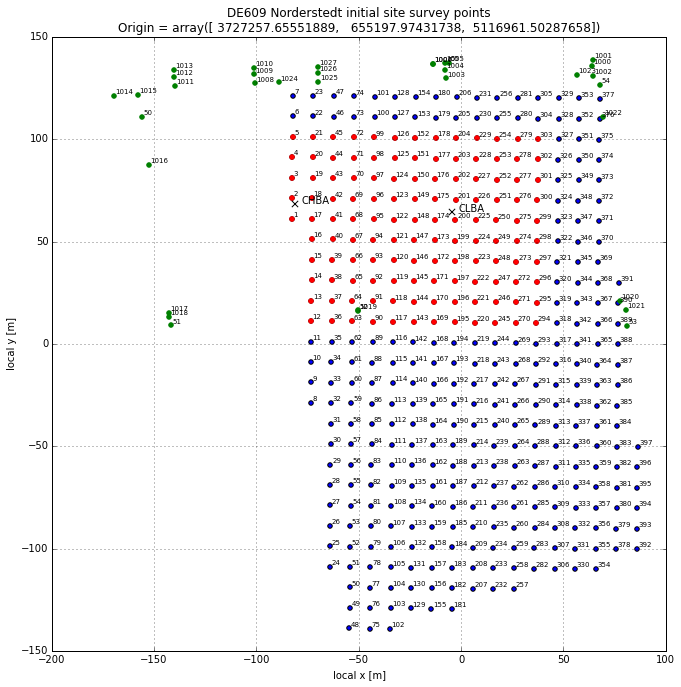

In [9]:
figure(figsize=(11,11))
scatter(local_north_xyz[:,0], local_north_xyz[:,1])
for name, offset in zip(all_names, local_north_xyz):
    text(offset[0]+1, offset[1]+1, name, fontsize=7)
ylim(-140, +130)
axis('equal')
grid()


title('DE609 Norderstedt initial site survey points\nOrigin = %r' %
      mean_position)
xlabel('local x [m]')
ylabel('local y [m]')

max_y = 105.0
min_y = 5.0
min_x = -120.
max_x = +45
selection_xyz = array([xyz for xyz in local_north_xyz
                      if xyz[0] > min_x and xyz[0] < max_x 
                      and xyz[1]> min_y and xyz[1] < max_y])
selection_etrs = array([etrs for etrs, xyz in zip(all_positions, local_north_xyz)
                      if xyz[0] > min_x and xyz[0] < max_x
                      and xyz[1]> min_y and xyz[1] < max_y])
scatter(selection_xyz[:,0], selection_xyz[:,1], color='red')
scatter(second_survey_xyz[:,0], second_survey_xyz[:,1], color='green')
for name, offset in zip(second_survey_names, second_survey_xyz):
    text(offset[0]+1, offset[1]+1, name, fontsize=7)
chba_xyz = transform([CHBA_ETRS], mean_position, local_north_projection.T)[0]
scatter(chba_xyz[0], chba_xyz[1], color='black', s=40, marker='x')
text(chba_xyz[0]+3, chba_xyz[1], 'CHBA', color='black')
clba_xyz = transform([CLBA_ETRS], mean_position, local_north_projection.T)[0]
scatter(clba_xyz[0], clba_xyz[1], color='black', s=40, marker='x')
text(clba_xyz[0]+3, clba_xyz[1], 'CLBA', color='black')

The red points (the ones in the *selection_xyz* and *selection_etrs* variables) are used to fit the best fit plane to the station. These points are all in the blue parallelogram-shaped boundary of the station in the technical drawing "Lageplan-LOFAR Norderstedt.dwg", dated 2014-05-16.

In [10]:
print ('The selection contains %d points.' % len(selection_etrs))

The selection contains 125 points.


The following function interpolates between unstructured points in 3D space.

In [11]:
from scipy.interpolate import Rbf # Radial basis function interpolation.
def interpolation_function(pqr):
    '''
    Return an interpolation function fn(x, y, z), which returns the value at x, y, 0.
    Make sure to pass an array of zeros the same shape as the x and y arrays.
    '''
    rbfi = Rbf(pqr[:,0], pqr[:,1], 0.0*pqr[:,2], pqr[:,2], function='linear')
    return rbfi

In [12]:
xyz_interpol_fn = interpolation_function(selection_xyz)
x_m, y_m = meshgrid(arange(-110, 50), arange(0,110))
z_m = xyz_interpol_fn(x_m, y_m, 0.0*y_m)

Now let's plot a map of elevation of the selection relative to the mean position of all points.

/usr/lib/python2.7/site-packages/matplotlib/text.py:52: UnicodeWarning: Unicode equal comparison failed to convert both arguments to Unicode - interpreting them as being unequal
  if rotation in ('horizontal', None):
/usr/lib/python2.7/site-packages/matplotlib/text.py:54: UnicodeWarning: Unicode equal comparison failed to convert both arguments to Unicode - interpreting them as being unequal
  elif rotation == 'vertical':


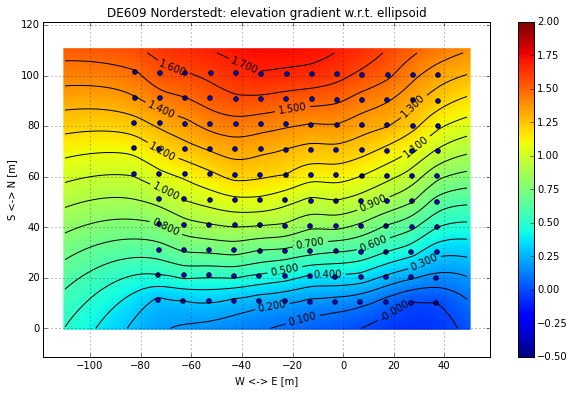

In [13]:
figure(figsize=(10,6))
imshow(z_m, origin='lower', vmin=-0.5, vmax=2.0, extent=(-110.5, 50.0, -0.5, 110.5))
colorbar()
cnt = contour(x_m, y_m, z_m, levels=arange(-0.50, 2.0, 0.10), colors='black')
cnt.clabel(inline=True)
xlabel('W <-> E [m]')
ylabel('S <-> N [m]')
axis('equal')
grid()
title('DE609 Norderstedt: elevation gradient w.r.t. ellipsoid')
scatter(selection_xyz[:,0], selection_xyz[:,1])


## Best fit plane and deviations from that plane

In [14]:
from numpy.linalg import lstsq

def fit_plane(xyz):
    # data_model z = ax +by +c
    # M colvec(a, b, c) = colvec(z)
    # M row i = (x_i, y_i, 1.0)
    mean_position = xyz.mean(axis=0)
    mat = array([xyz[:,0]- mean_position[0],
                 xyz[:,1]- mean_position[1],
                 ones(len(xyz[:,2]))]).T
    a, b, c = lstsq(mat, xyz[:,2] - mean_position[2])[0]
    normal_vector = array([-a, -b, 1.0])
    normal_vector /= norm(normal_vector)
    return {'mean': mean_position, 'normal': normal_vector}

In [15]:
solution = fit_plane(selection_etrs)
rotation_matrix_field = projection_matrix(LOFAR_XYZ0_m, solution['normal'])
print 'Normal vector: ', repr(solution['normal'])
print 'Mean position: ', repr(solution['mean'])
print 'Rotation matrix field:\n', repr(rotation_matrix_field)

Normal vector:  array([ 0.59468684,  0.10639085,  0.79688679])
Mean position:  array([ 3727216.76944 ,   655170.109392,  5116995.8456  ])
Rotation matrix field:
array([[-0.14021444, -0.79163595,  0.59468684],
       [ 0.98973915, -0.09538031,  0.10639085],
       [-0.02750141,  0.60350238,  0.79688679]])


In [16]:
station_pqr = transform(selection_etrs, solution['mean'], rotation_matrix_field.T)
station_height_deviation_fn = interpolation_function(station_pqr)
print 'p range: ', station_pqr[:,0].min(),'--', station_pqr[:,0].max()
print 'q range: ', station_pqr[:,1].min(),'--', station_pqr[:,1].max()

p range:  -63.8721334802 -- 59.1428997809
q range:  -47.7708354127 -- 45.944296728


In [17]:
p_m, q_m = meshgrid(arange(-75, 75), arange(-50, 50))
r_m = station_height_deviation_fn(p_m, q_m, 0.0*q_m)

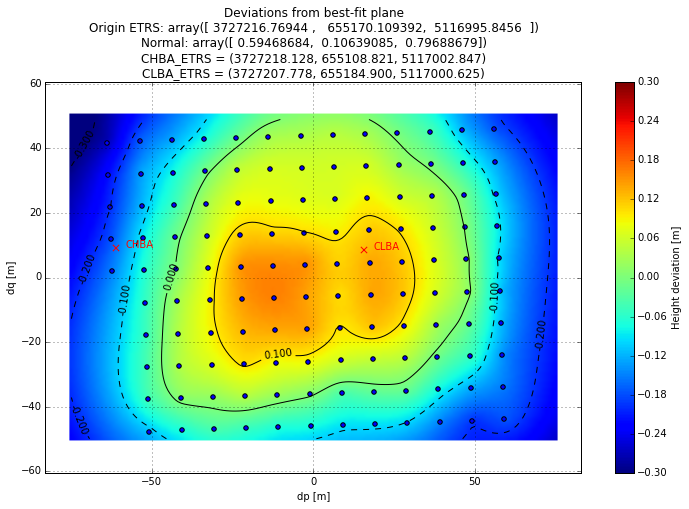

In [18]:
figure(figsize=(12, 7))
imshow(r_m, origin='lower', extent=(-75.5, 75.5, -50.5, 50.5), vmin=-0.3, vmax=+0.3)
axis('equal')
grid()
cb = colorbar()
cb.set_label('Height deviation [m]')
cnt = contour(p_m, q_m, r_m, levels=[-0.3, -0.2, -0.1, 0.0, 0.1, 0.2, 0.3], colors='black')
cnt.clabel(inline=True)
title('''Deviations from best-fit plane
Origin ETRS: %r\nNormal: %r
CHBA_ETRS = (%.3f, %.3f, %.3f)
CLBA_ETRS = (%.3f, %.3f, %.3f)''' %
      (solution['mean'], solution['normal'],
       CHBA_ETRS[0], CHBA_ETRS[1], CHBA_ETRS[2],
       CLBA_ETRS[0], CLBA_ETRS[1], CLBA_ETRS[2]))
xlabel('dp [m]')
ylabel('dq [m]')
scatter(station_pqr[:,0], station_pqr[:,1])
chba_pqr = transform([CHBA_ETRS], solution['mean'], rotation_matrix_field.T)[0]
scatter(chba_pqr[0], chba_pqr[1], color='red', s=40, marker='x')
text(chba_pqr[0]+3, chba_pqr[1], 'CHBA', color='red')
clba_pqr = transform([CLBA_ETRS], solution['mean'], rotation_matrix_field.T)[0]
scatter(clba_pqr[0], clba_pqr[1], color='red', s=40, marker='x')
text(clba_pqr[0]+3, clba_pqr[1], 'CLBA', color='red')


It is quite clear that less than half of the prospective HBA field has been surveyed, hence the previous request to observe an additional 35 m west of this area. However, since the geography of the field is very benign, this is unlikely to pose an insurmountable obstacle for the further rollout. The LBA and HBA centres were determined empirically by pretty much reading them off the screen. I have more confidence in the HBA centre's ETRS coordinates than the LBA centre's. 

Eim can still start with the drawing in the "PQR" system, with the origin at either the LBA or HBA centre. We should then pin the configuration to the real world after one of the two intended points has ETRS coordinates measured in the field.

## Reference direction

The reference direction is the northern bisector of the X- and Y- dipoles. It is the second column of the rotation matrix. At LOFAR core station CS002 LBA, the reference direction coincides with true north, but elsewhere there is a slight deviation to ensure that all dipoles in LOFAR are oriented as similarly as possible. In this section, I determine the deviation between the reference direction (the "q" axis) and geographic north in the ETRS89 reference system.

In [19]:
ref_dir = rotation_matrix_field[:,1] 
print 'Reference direction (q direction in ETRS89): ', ref_dir

Reference direction (q direction in ETRS89):  [-0.79163595 -0.09538031  0.60350238]


To determine the angle between the reference direction of the station and ETRS89 north, we need to project the reference direction onto the tangent plane to the ellipsoid at the mean position of the field, and compute the normalized inner product between the "reference direction" of the local north frame and the projected reference direction.

In [20]:
tip_refdir = solution['mean']+ref_dir
projected_tip_ref_dir = transform(array([tip_refdir]), solution['mean'],
                                  local_north_projection.T)[0]
projected_tip_ref_dir[2] = 0.0
projected_tip_ref_dir = dot(local_north_projection, projected_tip_ref_dir)
projected_tip_ref_dir /= norm(projected_tip_ref_dir)

etrs_north = local_north_projection[:,1]
deviation = arccos(inner(etrs_north, projected_tip_ref_dir))

In [21]:
print ('Reference direction for Norderstedt is %.4f degrees east from north.' %
       (deviation*180/pi,))

Reference direction for Norderstedt is 2.4715 degrees east from north.


### HBA and LBA centres

What is left now is to determine the planned centres for the HBA and LBA fields. This has been done by optically overlaying a Google Maps image containing the measured ETRS points on top of the technical drawing, and measuring the distances between the HBA centre, LBA centre, and various ETRS observations on the screen of the laptop. Aligning the ETRS data with the technical drawing was difficult because the land survey did not seem to include ETRS coordinates of at least 4 specific landmarks that can be found back on the technical drawing (unless I have missed those). I estimate the accuracy of the alignment to be about 1.5 m.

In the following cell, I determine the scale of my screen:

In [22]:
dist_003_199_cm = 13.9
dist_003_199_m = norm(all_positions[all_names.index('3'), :]
                      - all_positions[all_names.index('199'), :])
scale_m_per_cm = dist_003_199_m / dist_003_199_cm
print scale_m_per_cm, 'm per cm'

6.14762585086 m per cm


I subsequently measure distances to multiple points, and optimize the position of the HBA and LBA centres such that I minimize the difference between the measured distances and the distances for a given value of the centre position.

In [23]:
from scipy.optimize import fmin_bfgs

def find_position(initial_pos, distances_dict, positions_dict):
    def penalty_fn(pos):
        squared_diff = 0.0
        for name, distance in distances_dict.iteritems():
            squared_diff += (norm(pos-positions_dict[name]) - distance)**2
        return squared_diff
    result = fmin_bfgs(penalty_fn, initial_pos)
    return result
    

In [24]:
chba_distances_cm = {'3': 2.25, 
                     '19': 3.15, 
                     '18': 2.15,  
                     '17': 2.32, 
                     '15': 4.55, 
                     '42': 3.75, 
                     '41': 3.8}
chba_distances_m = dict([(key, value*scale_m_per_cm)
                         for key, value in chba_distances_cm.iteritems() ])
CHBA_ETRS_ESTIMATE = find_position(position_dict['17'], chba_distances_m, position_dict)
print 'CHBA_ETRS_ESTIMATE: ', CHBA_ETRS_ESTIMATE

clba_distances_cm = {'175': 1.85, 
                     '201':1.45, 
                     '148': 2.90, 
                     '200': 0.52, 
                     '147': 3.43, 
                     '173': 2.3, 
                     '199': 2.03}
clba_distances_m = dict([(key, value*scale_m_per_cm)
                         for key, value in clba_distances_cm.iteritems() ])
CLBA_ETRS_ESTIMATE = find_position(position_dict['200'], clba_distances_m, position_dict)
print 'CLBA_ETRS_ESTIMATE: ', CLBA_ETRS_ESTIMATE

Optimization terminated successfully.
         Current function value: 1.209123
         Iterations: 17
         Function evaluations: 105
         Gradient evaluations: 21
CHBA_ETRS_ESTIMATE:  [ 3727219.85688834   655104.69624212  5117002.01149518]
Optimization terminated successfully.
         Current function value: 0.229300
         Iterations: 9
         Function evaluations: 60
         Gradient evaluations: 12
CLBA_ETRS_ESTIMATE:  [ 3727210.72339844   655184.53745788  5117000.60903704]


In [25]:
print rotation_matrix_field

[[-0.14021444 -0.79163595  0.59468684]
 [ 0.98973915 -0.09538031  0.10639085]
 [-0.02750141  0.60350238  0.79688679]]


Let's now draw a map in the PQR system, using the best fit plane, and setting the origin to the centre of the LBA field.

In [26]:
CABINET_ETRS, POINT_1_CABLE_ETRS = (array([ 3727183.28093187,   655142.66602924,  5117022.35007821]),
                                     array([ 3727185.34672333,   655144.78305125,  5117020.58614552]))
CABINET_CORNERS_ETRS = array([[ 3727182.54113448,   655138.72848582,  5117023.38615333],
                              [ 3727181.24265226,   655146.11522691,  5117023.38615333],
                              [ 3727184.02072926,   655146.60357266,  5117021.31400309],
                              [ 3727185.31921148,   655139.21683157,  5117021.31400309],
                              [ 3727182.54113448,   655138.72848582,  5117023.38615333]])
TREE_1021_ETRS = array([ 3727230.757,   655274.889,  5116971.925])
TREE_1022_ETRS = array([ 3727158.331,   655250.784,  5117028.235])
TREE_1023_ETRS = array([ 3727144.564,   655235.551,  5117040.787])
TREE_1024_ETRS = array([ 3727172.84 ,   655092.658,  5117038.837])

FLAT_FIELD_CORNERS_PQR = array([[-120.9452, 29.3194, 0.0],
                                [35.1748, 54.3594, 0.0],
                                [49.6548, -37.0181, 0.0],
                                [-106.5841, -61.8362, 0.0]])
FLAT_FIELD_CORNERS_ETRS = transform(FLAT_FIELD_CORNERS_PQR, zeros(3),
                                    LBA_ROTATION_MATRIX)+CLBA_ETRS
FLAT_FIELD_CORNER_NAMES = [3501, 3502, 3503, 3504]

POI_NAMES = ['Cabinet', 'Cable 1', 'CLBA', 'CHBA', 'Tree1021', 'Tree1022', 'Tree1023', 'Tree1024']
POI_ETRS = array([CABINET_ETRS, POINT_1_CABLE_ETRS,
                  CLBA_ETRS, CHBA_ETRS,
                  TREE_1021_ETRS, TREE_1022_ETRS,
                  TREE_1023_ETRS, TREE_1024_ETRS])



In [27]:
def to_de609_pqr(etrs):
    rotation_matrix = array([
    [-0.13845476655396716, -0.8005033400537694, 0.583116352181317],
    [0.9900288727081186, -0.09644869337822555, 0.10266684347892051],
    [-0.025944340862288206, 0.591516738654446, 0.8058752006786344]])
    CLBA_ETRS = array([ 3727207.778, 655184.900, 5117000.625])
    origin = CLBA_ETRS
    return transform(etrs, origin, rotation_matrix.T)

In [28]:
print open('de609-hba-solution.lisp').read()

(discarded-points
    ("4063;3727222.064;655143.073;5116995.308;52.0"
     "4062;3727228.109;655142.561;5116990.999;52.0"
     "4061;3727233.347;655139.15;5116987.558;52.0"
     "4060;3727238.175;655134.65;5116984.519;52.0"
     "4059;3727242.355;655129.56;5116982.04;52.0"
     "4058;3727244.583;655123.287;5116981.152;52.0"
     "4057;3727247.382;655116.48;5116979.908;52.0"
     "4056;3727249.063;655109.824;5116979.465;52.0"
     "4055;3727249.257;655102.315;5116980.234;52.0"
     "4054;3727248.195;655094.714;5116981.981;52.0"
     "4053;3727245.582;655088.285;5116984.759;52.0"
     "4052;3727242.454;655082.506;5116987.84;52.0"
     "4051;3727237.904;655077.32;5116991.858;52.0"
     "4050;3727232.689;655074.611;5116996.135;52.0"
     "4049;3727227.929;655072.955;5116999.868;52.0"
     "4048;3727222.346;655072.138;5117004.121;52.0"
     "4047;3727216.652;655072.271;5117008.296;52.0"
     "4046;3727212.876;655073.415;5117010.873;52.0"
     "4045;3727208.125;655075.808;5117014.054;52.0"
 

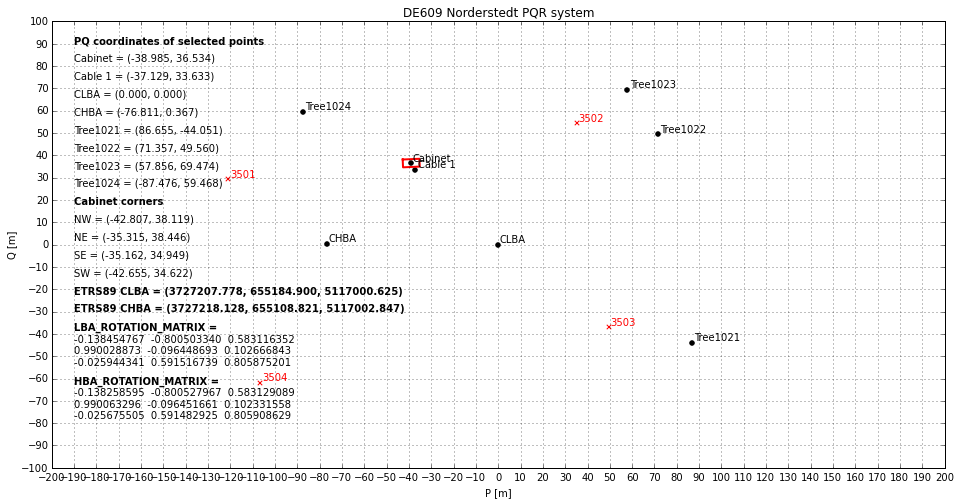

In [29]:
figure(figsize=(16, 8))

poi_pqr = to_de609_pqr(POI_ETRS)
scatter(poi_pqr[:, 0], poi_pqr[:,1], color='black')
line = 0
text(-190, 90 -line*8, 'PQ coordinates of selected points', fontweight='bold')
line+=1
for name, pqr in zip(POI_NAMES, poi_pqr):
    text(pqr[0]+1, pqr[1]+1, name, fontsize=10)
    text(-190, 90 -line*8, '%s = (%.3f, %.3f)' % (name, pqr[0], pqr[1]))
    line += 1
    
cabinet_pqr = to_de609_pqr(CABINET_CORNERS_ETRS)
text(-190, 90-line*8, 'Cabinet corners', fontweight='bold')
line += 1
for name, pqr in zip(['NW', 'NE', 'SE', 'SW'], cabinet_pqr[:-1,:]):
    text(-190, 90 -line*8, '%s = (%.3f, %.3f)' % (name, pqr[0], pqr[1]))
    line += 1
text(-190, 90-line*8, 'ETRS89 CLBA = (%.3f, %.3f, %.3f)' % (CLBA_ETRS[0], CLBA_ETRS[1], CLBA_ETRS[2]), fontweight='bold')
line += 1
text(-190, 90-line*8, 'ETRS89 CHBA = (%.3f, %.3f, %.3f)' % (CHBA_ETRS[0], CHBA_ETRS[1], CHBA_ETRS[2]), fontweight='bold')
line += 1
text(-190, 90-line*8, 'LBA_ROTATION_MATRIX =', fontweight='bold')
line += 2
r = LBA_ROTATION_MATRIX
text(-190, 90-line*8, '%.9f  %.9f  %.9f\n%.9f  %.9f  %.9f\n%.9f  %.9f  %.9f' %
     (r[0,0], r[0, 1], r[0,2], r[1,0], r[1,1], r[1,2], r[2,0], r[2,1], r[2,2]))
line+= 1
text(-190, 90-line*8, 'HBA_ROTATION_MATRIX =', fontweight='bold')
line += 2
r = HBA_ROTATION_MATRIX
text(-190, 90-line*8, '%.9f  %.9f  %.9f\n%.9f  %.9f  %.9f\n%.9f  %.9f  %.9f' %
     (r[0,0], r[0, 1], r[0,2], r[1,0], r[1,1], r[1,2], r[2,0], r[2,1], r[2,2]))


scatter(FLAT_FIELD_CORNERS_PQR[:,0], FLAT_FIELD_CORNERS_PQR[:,1], color='red', marker='x')
for name, pqr in zip(FLAT_FIELD_CORNER_NAMES, FLAT_FIELD_CORNERS_PQR):
    text(pqr[0]+1, pqr[1]+1, name, fontsize=10, color='red')

plot(cabinet_pqr[:,0], cabinet_pqr[:,1], linewidth=2, color='red')
grd = grid()
axis('equal')
xticks(arange(-200, 201, 10))
yticks(arange(-200, 201, 10))
xlabel('P [m]')
ylabel('Q [m]')
title('DE609 Norderstedt PQR system')
savefig('de609-norderstedt-reference-points-pqr.pdf')

In [30]:
with open('de609-norderstedt-flat-field-boundary.csv', 'w') as out:
    out.write('#NAME,ETRS-X,ETRS-Y,ETRS-Z\n')
    for name, xyz in zip(FLAT_FIELD_CORNER_NAMES, FLAT_FIELD_CORNERS_ETRS):
        line = '%s,%.3f,%.3f,%.3f' % (name, xyz[0], xyz[1], xyz[2])
        out.write(line+'\n')
        print line

3501,3727201.053,655062.333,5117021.106
3502,3727159.393,655214.481,5117031.867
3503,3727230.536,655237.630,5116977.440
3504,3727272.035,655085.343,5116966.813


In [31]:
with open('de609-norderstedt-cabinet-corners.csv', 'w') as out:
    out.write('#NAME,ETRS-X,ETRS-Y,ETRS-Z\n')
    for name, xyz in zip(['3511', '3512', '3513', '3514'], CABINET_CORNERS_ETRS):
        line = '%s,%.3f,%.3f,%.3f' % (name, xyz[0], xyz[1], xyz[2])
        out.write(line+'\n')
        print line

3511,3727182.541,655138.728,5117023.386
3512,3727181.243,655146.115,5117023.386
3513,3727184.021,655146.604,5117021.314
3514,3727185.319,655139.217,5117021.314


## Field flatness validation d.d. 2014-09-26

In [43]:
lba_rows = read_etrs_csv('flatness-validation/14145T03_ECEF_LBA.csv', delimiter=',')
lba_names = names_from_rows(lba_rows)
lba_points = positions_from_rows(lba_rows)
lba_solution = fit_plane(lba_points)
lba_rotation_matrix = projection_matrix(LOFAR_XYZ0_m, lba_solution['normal'])
print lba_solution
print lba_rotation_matrix

hba_rows = read_etrs_csv('flatness-validation/14145T03_ECEF_HBA.csv', delimiter=',')
hba_names = names_from_rows(hba_rows)
hba_points = positions_from_rows(hba_rows)
hba_solution = fit_plane(hba_points)
hba_rotation_matrix = projection_matrix(LOFAR_XYZ0_m, hba_solution['normal'])
print hba_solution
print hba_rotation_matrix


{'normal': array([ 0.58546852,  0.10368632,  0.80403716]), 'mean': array([ 3727207.27413931,   655186.51227363,  5117000.71752737])}
[[-0.13896188 -0.79869657  0.58546852]
 [ 0.98994381 -0.096231    0.10368632]
 [-0.02647368  0.59398939  0.80403716]]
{'normal': array([ 0.58586748,  0.10161019,  0.80401161]), 'mean': array([ 3727219.60420946,   655107.8207027 ,  5117001.81894595])}
[[-0.13772952 -0.79861748  0.58586748]
 [ 0.99015999 -0.09622148  0.10161019]
 [-0.02477464  0.59409726  0.80401161]]


In [33]:
arccos(inner(hba_solution['normal'], solution['normal']))*180/pi

0.70499617474580134

In [34]:
hba_solution

{'mean': array([ 3727219.60420946,   655107.8207027 ,  5117001.81894595]),
 'normal': array([ 0.58586748,  0.10161019,  0.80401161])}

In [35]:
station_pqr = transform(concatenate([lba_points, hba_points], axis=0),
                        CLBA_ETRS, LBA_ROTATION_MATRIX.T)#local_north_projection.T)
station_height_deviation_fn = interpolation_function(station_pqr)
print 'p range: ', station_pqr[:,0].min(),'--', station_pqr[:,0].max()
print 'q range: ', station_pqr[:,1].min(),'--', station_pqr[:,1].max()

p range:  -113.745346199 -- 43.4370453668
q range:  -40.8991289701 -- 40.1085601965


In [36]:
p_m, q_m = meshgrid(arange(-120, 50), arange(-50, 50))
r_m = station_height_deviation_fn(p_m, q_m, 0.0*q_m)

<matplotlib.contour.QuadContourSet instance at 0x7f6e2c03f908>

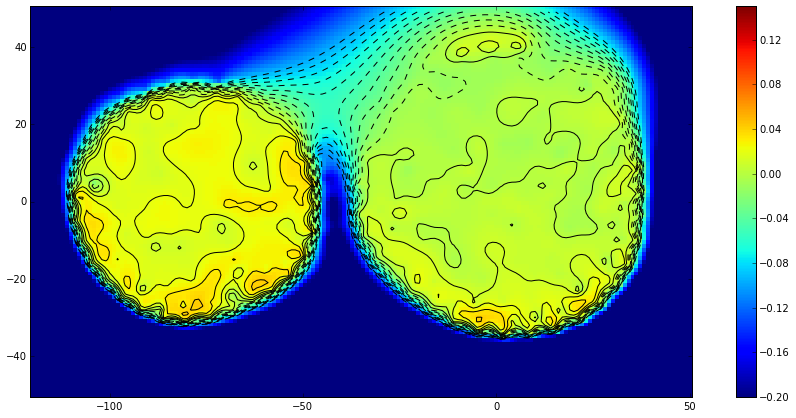

In [37]:
figure(figsize=(16,7))
imshow(r_m, interpolation='nearest', origin='lower', extent=(-120.5, 50.5, -50.5, 50.5), vmin=-0.2, vmax=0.15)
colorbar()
contour(p_m, q_m, r_m, levels=arange(-0.1, 0.1, 0.01), colors='black')


Bosma verwacht dat het niet inklinkt. Eerst met HBA beginnen.

In [38]:
local_north_rotation_matrix = LBA_ROTATION_MATRIX #projection_matrix(LOFAR_XYZ0_m, ellipsoid_normal)
tip_refdir = CLBA_ETRS+local_north_rotation_matrix[:,1]
projected_tip_ref_dir = transform(array([tip_refdir]), CLBA_ETRS,
                                  local_north_rotation_matrix.T)[0]
projected_tip_ref_dir[2] = 0.0
projected_tip_ref_dir = dot(local_north_rotation_matrix, projected_tip_ref_dir)
projected_tip_ref_dir /= norm(projected_tip_ref_dir)

etrs_north = local_north_projection[:,1]
deviation = arccos(inner(etrs_north, projected_tip_ref_dir))

In [39]:
print ('Reference direction for Norderstedt is %.4f degrees east from north.' %
       (deviation*180/pi,))

Reference direction for Norderstedt is 2.4989 degrees east from north.


## Map of all stake positions

In [40]:
lba_etrs_rows = read_etrs_csv('de609-lba-stakes-etrs-ls.csv', delimiter=',')
lba_stake_names = names_from_rows(lba_etrs_rows)
lba_stake_etrs = positions_from_rows(lba_etrs_rows)

hba_etrs_rows = read_etrs_csv('de609-hba-stakes-etrs-ls.csv', delimiter=',')
hba_stake_names = names_from_rows(hba_etrs_rows)
hba_stake_etrs = positions_from_rows(hba_etrs_rows)

all_names = lba_stake_names + hba_stake_names + ['3511', '3512', '3513', '3514']# + FLAT_FIELD_CORNER_NAMES
all_etrs = concatenate([lba_stake_etrs, hba_stake_etrs, CABINET_CORNERS_ETRS[0:4,:]], axis=0) #, FLAT_FIELD_CORNERS_ETRS

In [41]:
all_pqr_north = transform(all_etrs, CLBA_ETRS, local_north_projection.T)

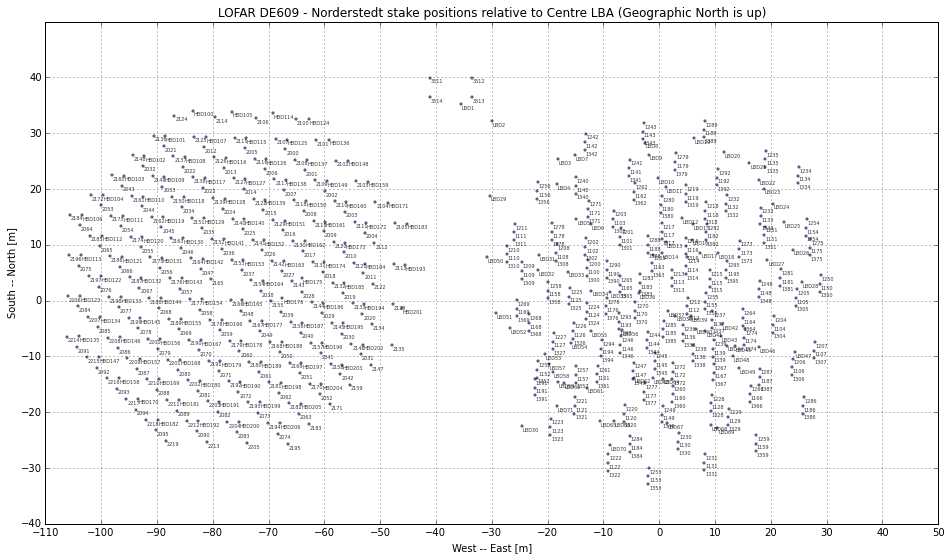

In [42]:
figure(figsize=(16,9))
scatter(all_pqr_north[:,0], all_pqr_north[:,1], alpha=0.5, s=5)
for name, pqr in zip(all_names, all_pqr_north):
    text(pqr[0]+.2, pqr[1]-.2, name, fontsize=5, alpha=0.8,
         verticalalignment='top')
axis('equal')
xticks(arange(-150,100,10))
yticks(arange(-40, 50,10))
grid()
xlabel('West -- East [m]')
ylabel('South -- North [m]')
title('LOFAR DE609 - Norderstedt stake positions relative to Centre LBA (Geographic North is up)')
savefig('de609-stake-positions.pdf')